<a href="https://colab.research.google.com/github/ajurberg/article-parser/blob/main/08_LDA_wordcloud_gdf11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################# 
#@title Installation of libraries 
#############################
import os
from time import time
import re, string, unicodedata
from string import punctuation
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
############################# 
#@title Mounting Google Drive
#############################
from google.colab import drive
drive._mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/papers'
os.chdir(workdir_path)

Mounted at /content/drive


In [69]:
############################# 
#@title Read json file to dictionary
#############################
import json

with open("gdf11-dictionary-word-tokens-stop.json") as json_file:
  gdf11_dict = json.load(json_file)

#@markdown Files to evaluate
#@markdown - `gdf11-dictionary.json` (no preprocessing)
#@markdown - `gdf11-dictionary-sent-tokens.json` (tokenized sentences)
#@markdown - `gdf11-dictionary-sent-tokens-stop.json` (tokenized sentences with removal of stopwords)
#@markdown - `gdf11-dictionary-word-tokens.json` (tokenized words)
#@markdown - `gdf11-dictionary-word-tokens-stop.json` (tokenized words with removal of stopwords)

In [4]:
############################# 
#@title LDA - alocação latente de Dirichlet
#############################
! python -m pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 29.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=a1e56f18b53eef289bcdf04ad1a4bf4ea20a2d78b6565dba75f89db843904837
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [6]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Visualization
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# Other libraries
from operator import itemgetter
import collections.abc
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

np.random.seed(0)

In [70]:
# Word vectorization: TF-IDF
vectorizer_bs = TfidfVectorizer(analyzer='word',       
                             lowercase=True,                   # converter todas as palavras em minúsculas
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3 - para ser qualificado como token
                             ngram_range = (2,3),              # uni, bi e trigrams
                             max_features=300
                            )

data_vectorized_bs = vectorizer_bs.fit_transform(gdf11_dict)

In [71]:
# Using GridSearch to find the best LDA model

# Search parameters
search_params = {'n_components': [3, 5, 10, 15], 'learning_decay': [.3, .5, .7, .9]}

# Model initialization
lda = LatentDirichletAllocation()

# Inicialization of Grid Search Class
model_bs = GridSearchCV(lda, param_grid=search_params)

# Generates a Grid Search
model_bs.fit(data_vectorized_bs)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.3, 0.5, 0.7, 0.9],
                         'n_components': [3, 5, 10, 15]})

In [72]:
# Best model
best_lda_model_bs = model_bs.best_estimator_

# Model hyperparameters
print("Melhores parâmetros: ", model_bs.best_params_)

# Logarithmic probability
print("Melhor score de probabilidade logarítmica: ", model_bs.best_score_)

# Perplexity
print("Perplexidade do modelo: ", best_lda_model_bs.perplexity(data_vectorized_bs))

# Use the best model
lda_output_bs = best_lda_model_bs.transform(data_vectorized_bs)

Melhores parâmetros:  {'learning_decay': 0.3, 'n_components': 3}
Melhor score de probabilidade logarítmica:  -576.6094294931414
Perplexidade do modelo:  1258.59055516946


In [73]:
# pyLDAvis visualization
pyLDAvis.enable_notebook() 
panel = pyLDAvis.sklearn.prepare(best_lda_model_bs, data_vectorized_bs, vectorizer_bs, mds='tsne')
pyLDAvis.save_html(panel, 'lda_bs.html') 
pyLDAvis.display(panel)

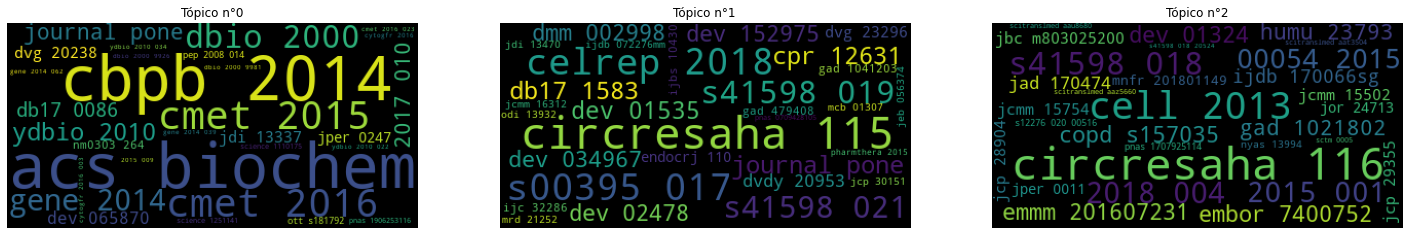

In [74]:
# Wordcloud
tf_feature_names_bs = vectorizer_bs.get_feature_names()

fig = plt.figure(figsize=(25,20))
for i in range(len(best_lda_model_bs.components_)):
  topic = best_lda_model_bs.components_[i]
  tupleList = [(tf_feature_names_bs[i], int(topic[i]/topic.sum()*10000)) for i in range(len(topic))]
  ax = fig.add_subplot(3,3,i+1)
  wordcloud = WordCloud(max_words=30).generate_from_frequencies(dict(tupleList))
  ax.imshow(wordcloud)
  ax.set_title('Tópico n°{}' .format(i))
  ax.axis('off');

# Not used

In [ ]:
#### dictionay iteration
# count = 0
# for key, text in tqdm(cleaned_dict.items()):
#   print(key, ":", text)
#   count += 1
#   if count == 5:
#     break

In [ ]:
# texts = [[text for text in l_] for l_ in gdf11_dict.values()]  # Convert dict_values to list
# flat_texts = [item for sublist in texts for item in sublist]   # Flat list out of a list of lists
# string_text = " ".join(flat_texts)                             # Convert list to string